In [ ]:
!rm -rf images assets
!pip install numpy==1.17.0
!pip install tensorflow==1.15.2
!pip install keras==2.1.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.77 MiB | 35.56 MiB/s, done.
Resolving deltas: 100% (565/565), done.


In [ ]:
!git clone https://github.com/stressGC/Food-Boundary-Box-Detection-Dataset.git

Cloning into 'Food-Boundary-Box-Detection-Dataset'...
remote: Enumerating objects: 5192, done.
remote: Total 5192 (delta 0), reused 0 (delta 0), pack-reused 5192
Receiving objects: 100% (5192/5192), 262.93 MiB | 24.38 MiB/s, done.
Resolving deltas: 100% (2125/2125), done.
Checking out files: 100% (3888/3888), done.


In [ ]:
%cd /content/Mask_RCNN

/content/Mask_RCNN


In [ ]:
!python3 setup.py install

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling build/bdist.linux-x86_64/egg/mrcnn/utils.py to utils.cpyt

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

from mrcnn import model as modellib
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
from matplotlib.patches import Rectangle
from keras.models import load_model
%matplotlib inline
from os import listdir
from xml.etree import ElementTree



Using TensorFlow backend.


In [ ]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
Food_MODEL_PATH = os.path.join('/content/drive/My Drive/Model/trainedmodel_101class.hdf5')

MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [ ]:
def get_data_extract(name, link, folder, formatt):
  if folder in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    name,
    link,
    cache_subdir='/content',
    extract=True,
    archive_format=formatt,
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

In [ ]:
# Download data and extract it to folder
get_data_extract('food-101.tar.gz', 'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz', "food-101", 'tar')

4996284416/4996278331 [==============================] - 762s 0us/step
Dataset downloaded and extracted!


In [ ]:
!unzip '/content/drive/My Drive/Model/food-101_annotations.zip' -d '/content/'

Archive:  /content/drive/My Drive/Model/food-101_annotations.zip
   creating: /content/food-101_annotations/
   creating: /content/food-101_annotations/french_fries/
  inflating: /content/food-101_annotations/french_fries/100148.xml  
  inflating: /content/food-101_annotations/french_fries/10500.xml  
  inflating: /content/food-101_annotations/french_fries/106608.xml  
  inflating: /content/food-101_annotations/french_fries/107312.xml  
  inflating: /content/food-101_annotations/french_fries/108743.xml  
  inflating: /content/food-101_annotations/french_fries/10897.xml  
  inflating: /content/food-101_annotations/french_fries/109401.xml  
  inflating: /content/food-101_annotations/french_fries/110385.xml  
  inflating: /content/food-101_annotations/french_fries/112309.xml  
  inflating: /content/food-101_annotations/french_fries/114269.xml  
  inflating: /content/food-101_annotations/french_fries/123902.xml  
  inflating: /content/food-101_annotations/french_fries/123929.xml  
  inflat

## Configurations

In [ ]:
class FoodConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "Foods"

    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background)
     # kangaroo + BG
    NUM_CLASSES = 1 + 31
    
    LEARNING_RATE = 0.001
    # setting Max ground truth instances
    #MAX_GT_INSTANCES = 10
    
config = FoodConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                44
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [ ]:
classes = ["apple_pie", "baklava", "beef_tartare", "beet_salad", "bibimbap", "bread_pudding"
        , "breakfast_burrito", "cannoli", "cheesecake", "chicken_wings", "chocolate_cake"
        , "cup_cakes", "deviled_eggs", "donuts", "dumplings", "falafel", "french_fries"
        , "fried_rice", "garlic_bread", "hamburger", "hot_dog", "ice_cream", "peking_duck"
        , "pho", "pizza", "ramen", "samosa", "steak", "sushi", "tiramisu", "waffles"]

In [ ]:
class FoodDataset(utils.Dataset):
    

    def load_Foods(self, dataset_dir, is_train=True):
        
        # Add classes
        for i in range(len(classes)):
          self.add_class("Foods", i + 1, classes[i])

        annotations = '/content/food-101_annotations/'
        for i in range(len(classes)):
          images_dir = dataset_dir + classes[i] + '/'
          annotations_dir = annotations + classes[i] + '/'
          count = 0
          for filename in listdir(annotations_dir):
              # extract image id
              image_id = filename[0 : -4]
              print(image_id)
              #f = False
              #if image_id == '':
              #  continue
              #for k in range(len(image_id)):
              #  if image_id[k] < '0' or image_id[k] > '9':
              #    f = True
              #    break
              #if f:
              #  continue
              
              # skip bad images
              #if image_id in ['00090']:
              #    continue
              # skip all images after 150 if we are building the train set
              count += 1
              if is_train and count > 75:
                  continue
              # skip all images before 150 if we are building the test/val set
              if not is_train and count <= 75:
                  continue
              
              # setting image file
              img_path = images_dir + image_id + '.jpg'
              
              # setting annotations file
              ann_path = annotations_dir + filename
              
              # adding images and annotations to dataset
              self.add_image('Foods', image_id=image_id, path=img_path, annotation=ann_path)

    # extract bounding boxes from an annotation file

    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        names = list()
        for ob in root.findall('.//object'):
          names.append(ob.find('name').text)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height, names

# load the masks for an image
    """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        
        # define anntation  file location
        path = info['annotation']
        # load XML
        boxes, w, h, names = self.extract_boxes(path)

        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            if names[i] == "chocolate cake":
              names[i] = "chocolate_cake"
            if names[i] == "ice cream":
              names[i] = "ice_cream"
            if names[i] not in self.class_names:
              names[i] = "BG"
            class_ids.append(self.class_names.index(names[i]))
        return masks, asarray(class_ids, dtype='int32')
# load an image reference """Return the path of the image."""
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

In [ ]:
# prepare train set
train_set = FoodDataset()
train_set.load_Foods('/content/food-101/images/', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = FoodDataset()
test_set.load_Foods('/content/food-101/images/', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Streaming output truncated to the last 5000 lines.
158588
178439
91203
20827
114847
120909
145254
96964
154146
45191
96277
67469
91387
185423
3080254
3776677
1467916
2219328
3318323
3704320
1335600
589111
2778130
174913
488974
197585
293037
3185808
1805041
683874
1734815
1087186
575764
3647416
591284
2503903
3296368
3056757
2448321
926305
3425745
3463815
2299719
1999024
2330276
1034462
1687583
1010482
3842335
1446781
3906356
1073100
2134598
2416784
1501227
3204622
3038851
2578770
2874110
1284518
2697260
2915439
1371868
114160
3113585
1296591
1075602
797341
891166
1787674
168562
752401
1919689
3814141
982237
1484570
1231284
1923960
1263028
2621320
1133490
1171668
1555646
2559972
2337508
102827
1562221
2222950
3292922
1145362
1255565
3104063
1594785
417219
122687
3883846
1342957
1235123
264324
2512435
2179793
3227184
2002373
1975338
2382415
268408
1379911
1773668
3719499
3491525
3123467
1157135
974426
514993
100786
205353
34342
91590
197068
42050
137585
129296
53695
191469
136841
139130


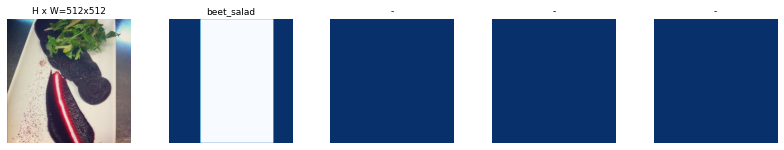

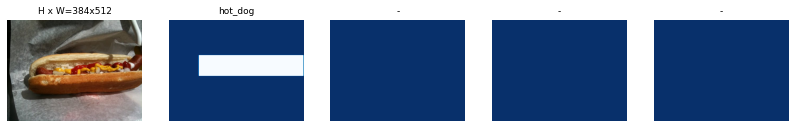

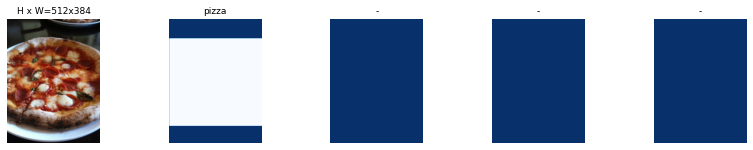

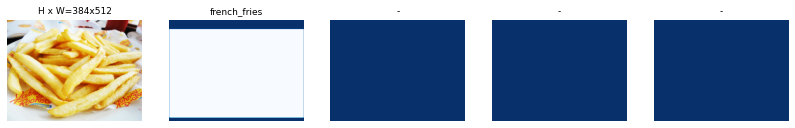

In [ ]:
# Load and display random samples
image_ids = np.random.choice(train_set.image_ids, 4)
for image_id in image_ids:
    image = train_set.load_image(image_id)
    mask, class_ids = train_set.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_set.class_names)

## Create Model

In [ ]:
# Create model in training mode
MODEL_DIR = '/content/drive/My Drive/Model/Segmentation/'
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
#from keras.utils.data_utils import get_file
#weights_path = get_file(Food_MODEL_PATH,
#                        TF_WEIGHTS_PATH_NO_TOP,
#                        cache_subdir='content',
#                        md5_hash='a268eb855778b3df3c7506639542a6af')

init_with = "imagenet"  # imagenet, coco, or last

if init_with == "Food":
   model.load_weights(Food_MODEL_PATH, by_name=True)
elif init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
model.load_weights('/content/drive/My Drive/Model/Segmentation/foods20200810T1453/mask_rcnn_foods_0011.h5', by_name=True)

Re-starting from epoch 11


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(train_set, test_set, 
            learning_rate=config.LEARNING_RATE, 
            epochs=2, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/Model/Segmentation/foods20200810T1453/mask_rcnn_foods_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribut

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers 

Epoch 1/2
  25/1000 [..............................] - ETA: 34:08 - loss: 3.9791 - rpn_class_loss: 0.3419 - rpn_bbox_loss: 1.5299 - mrcnn_class_loss: 0.4896 - mrcnn_bbox_loss: 0.9855 - mrcnn_mask_loss: 0.6322

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2293760 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))


  65/1000 [>.............................] - ETA: 24:16 - loss: 3.4627 - rpn_class_loss: 0.1660 - rpn_bbox_loss: 1.3254 - mrcnn_class_loss: 0.3765 - mrcnn_bbox_loss: 0.9205 - mrcnn_mask_loss: 0.6744

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 655360 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))


 324/1000 [========>.....................] - ETA: 14:28 - loss: 2.9121 - rpn_class_loss: 0.0694 - rpn_bbox_loss: 1.0554 - mrcnn_class_loss: 0.3563 - mrcnn_bbox_loss: 0.7671 - mrcnn_mask_loss: 0.6639

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1769472 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33555456 bytes but only got 0. Skipping tag 59392
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))


 505/1000 [==============>...............] - ETA: 10:23 - loss: 2.8413 - rpn_class_loss: 0.0556 - rpn_bbox_loss: 1.0534 - mrcnn_class_loss: 0.3549 - mrcnn_bbox_loss: 0.7318 - mrcnn_mask_loss: 0.6455

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))


 820/1000 [=======================>......] - ETA: 3:43 - loss: 2.6705 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 0.9827 - mrcnn_class_loss: 0.3470 - mrcnn_bbox_loss: 0.6937 - mrcnn_mask_loss: 0.6008

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2686976 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1114112 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


 909/1000 [==========================>...] - ETA: 1:52 - loss: 2.6370 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 0.9757 - mrcnn_class_loss: 0.3465 - mrcnn_bbox_loss: 0.6842 - mrcnn_mask_loss: 0.5853

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1769472 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33555456 bytes but only got 0. Skipping tag 59392
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))


 991/1000 [============================>.] - ETA: 11s - loss: 2.6131 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 0.9712 - mrcnn_class_loss: 0.3480 - mrcnn_bbox_loss: 0.6754 - mrcnn_mask_loss: 0.5742

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2097152 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))


 999/1000 [============================>.] - ETA: 1s - loss: 2.6186 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 0.9786 - mrcnn_class_loss: 0.3474 - mrcnn_bbox_loss: 0.6745 - mrcnn_mask_loss: 0.5735

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3276800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))


1000/1000 [==============================] - 1671s 2s/step - loss: 2.6183 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 0.9788 - mrcnn_class_loss: 0.3474 - mrcnn_bbox_loss: 0.6743 - mrcnn_mask_loss: 0.5732 - val_loss: 2.0771 - val_rpn_class_loss: 0.0187 - val_rpn_bbox_loss: 0.6845 - val_mrcnn_class_loss: 0.3464 - val_mrcnn_bbox_loss: 0.5695 - val_mrcnn_mask_loss: 0.4580
Epoch 2/2
 152/1000 [===>..........................] - ETA: 17:11 - loss: 2.3460 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 0.8985 - mrcnn_class_loss: 0.3980 - mrcnn_bbox_loss: 0.5511 - mrcnn_mask_loss: 0.4538

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1703936 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3407872 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


 227/1000 [=====>........................] - ETA: 15:39 - loss: 2.3063 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.9091 - mrcnn_class_loss: 0.3696 - mrcnn_bbox_loss: 0.5399 - mrcnn_mask_loss: 0.4500

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1376256 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))


 366/1000 [=========>....................] - ETA: 12:52 - loss: 2.2055 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.8508 - mrcnn_class_loss: 0.3536 - mrcnn_bbox_loss: 0.5262 - mrcnn_mask_loss: 0.4425

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2752512 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))


 440/1000 [============>.................] - ETA: 11:22 - loss: 2.1577 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.8167 - mrcnn_class_loss: 0.3481 - mrcnn_bbox_loss: 0.5228 - mrcnn_mask_loss: 0.4400

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2097152 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))


 486/1000 [=============>................] - ETA: 10:26 - loss: 2.1585 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.8231 - mrcnn_class_loss: 0.3393 - mrcnn_bbox_loss: 0.5220 - mrcnn_mask_loss: 0.4392

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 655360 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))


 497/1000 [=============>................] - ETA: 10:13 - loss: 2.1545 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.8237 - mrcnn_class_loss: 0.3388 - mrcnn_bbox_loss: 0.5197 - mrcnn_mask_loss: 0.4374

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1703936 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3407872 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


 871/1000 [=========================>....] - ETA: 2:37 - loss: 2.1583 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.8303 - mrcnn_class_loss: 0.3594 - mrcnn_bbox_loss: 0.5096 - mrcnn_mask_loss: 0.4250

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1703936 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))


1000/1000 [==============================] - 1259s 1s/step - loss: 2.1423 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.8272 - mrcnn_class_loss: 0.3607 - mrcnn_bbox_loss: 0.5028 - mrcnn_mask_loss: 0.4188 - val_loss: 2.1984 - val_rpn_class_loss: 0.0174 - val_rpn_bbox_loss: 0.9105 - val_mrcnn_class_loss: 0.3470 - val_mrcnn_bbox_loss: 0.5061 - val_mrcnn_mask_loss: 0.4173


In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(train_set, test_set, 
            learning_rate=config.LEARNING_RATE,
            epochs=100, 
            layers="all")


Starting at epoch 11. LR=0.001

Checkpoint Path: /content/drive/My Drive/Model/Segmentation/foods20200810T1453/mask_rcnn_foods_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Con

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers 

Epoch 12/100


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2752512 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))


   8/1000 [..............................] - ETA: 20:23:48 - loss: 1.3236 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.4385 - mrcnn_class_loss: 0.2734 - mrcnn_bbox_loss: 0.2848 - mrcnn_mask_loss: 0.3173

Process Process-3:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py", line 631, in data_generator_task
    self.queue.put(generator_output)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 82, in put
    if not self._sem.acquire(block, timeout):
  File "/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py", line 631, in data_generator_task
    self.queue.put(generator_output)
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessin

KeyboardInterrupt: ignored

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(train_set, test_set, 
            learning_rate=config.LEARNING_RATE / 100,
            epochs=50, 
            layers="all")


Starting at epoch 12. LR=1e-05

Checkpoint Path: /content/drive/My Drive/Model/Segmentation/foods20200808T2123/mask_rcnn_foods_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Con

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers 

Epoch 13/50
  85/1000 [=>............................] - ETA: 22:11 - loss: 2.0042 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.7903 - mrcnn_class_loss: 0.3313 - mrcnn_bbox_loss: 0.4299 - mrcnn_mask_loss: 0.4177

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))


 375/1000 [==========>...................] - ETA: 10:36 - loss: 2.0063 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.8135 - mrcnn_class_loss: 0.3339 - mrcnn_bbox_loss: 0.4202 - mrcnn_mask_loss: 0.4065

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2293760 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))


 399/1000 [==========>...................] - ETA: 10:07 - loss: 2.0291 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.8407 - mrcnn_class_loss: 0.3324 - mrcnn_bbox_loss: 0.4194 - mrcnn_mask_loss: 0.4049

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1769472 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33555456 bytes but only got 0. Skipping tag 59392
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))


 446/1000 [============>.................] - ETA: 9:13 - loss: 2.0149 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.8143 - mrcnn_class_loss: 0.3374 - mrcnn_bbox_loss: 0.4239 - mrcnn_mask_loss: 0.4088

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))


 516/1000 [==============>...............] - ETA: 7:56 - loss: 2.0364 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.8344 - mrcnn_class_loss: 0.3386 - mrcnn_bbox_loss: 0.4238 - mrcnn_mask_loss: 0.4065

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1769472 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33555456 bytes but only got 0. Skipping tag 59392
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))


 650/1000 [==================>...........] - ETA: 5:37 - loss: 2.0309 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.8189 - mrcnn_class_loss: 0.3405 - mrcnn_bbox_loss: 0.4304 - mrcnn_mask_loss: 0.4076

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 3. 
  warnings.warn(str(msg))


 731/1000 [====================>.........] - ETA: 4:17 - loss: 2.0422 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.8336 - mrcnn_class_loss: 0.3373 - mrcnn_bbox_loss: 0.4301 - mrcnn_mask_loss: 0.4066

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2228224 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 11. 
  warnings.warn(str(msg))


 999/1000 [============================>.] - ETA: 0s - loss: 2.0348 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.8279 - mrcnn_class_loss: 0.3373 - mrcnn_bbox_loss: 0.4261 - mrcnn_mask_loss: 0.4082

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


OSError: ignored

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.load_weights('/content/drive/My Drive/Model/Segmentation/foods20200808T1558/mask_rcnn_foods_0008.h5', by_name=True)
model.train(train_set, test_set, 
            learning_rate=config.LEARNING_RATE / 100,
            epochs=5, 
            layers="all")

Re-starting from epoch 8

Starting at epoch 8. LR=1e-05

Checkpoint Path: /content/drive/My Drive/Model/Segmentation/foods20200808T1558/mask_rcnn_foods_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers 

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(FoodConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model2 = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = '/content/drive/My Drive/Model/Segmentation/foods20200810T1453/mask_rcnn_foods_0011.h5'

# Load trained weights
print("Loading weights from ", model_path)
model2.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/drive/My Drive/Model/Segmentation/foods20200810T1453/mask_rcnn_foods_0011.h5
Re-starting from epoch 11


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (44,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:   12.00000  max:   12.00000  int32
gt_bbox                  shape: (1, 4)                min:  292.00000  max:  898.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


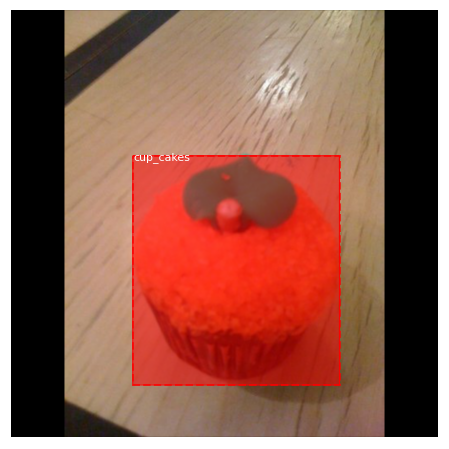

In [ ]:
# Test on a random image
image_id = random.choice(test_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(test_set, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            train_set.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 44)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



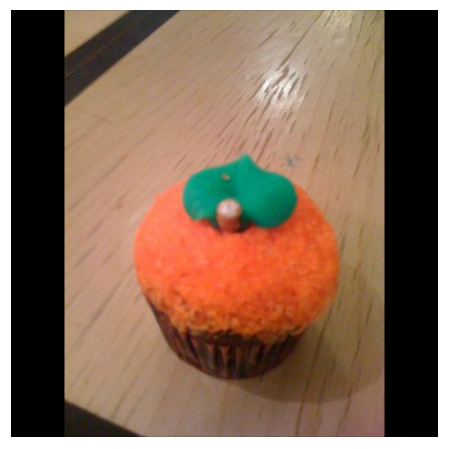

In [ ]:
#original_image = plt.imread('/content/baklava.jpeg')
results = model2.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            train_set.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(test_set.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(test_set, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.0
